In [1]:
from game import Game


n_players = 5
# 7 type is minimax
player_types = [7 for p in range(n_players)]
game = Game(map="USA", player_types=player_types, players_num=len(player_types))
game.start()

In [2]:
for i, terr in enumerate(game.json()['territories']):
    print(terr['name'])
    print([adj_terr for adj_terr in terr['adjacent_territories']])

Alabama
['Mississippi', 'Tennessee', 'Florida', 'Georgia']
Alaska
['Hawaii', 'California', 'Arizona']
Arizona
['California', 'Nevada', 'Utah', 'New Mexico', 'Colorado']
Arkansas
['Tennessee', 'Missouri', 'Oklahoma', 'Mississippi', 'Louisiana', 'Texas']
California
['Nevada', 'Arizona', 'Alaska']
Colorado
['Utah', 'Wyoming', 'Arizona', 'New Mexico', 'Nebraska', 'Kansas', 'Oklahoma']
Connecticut
['New York', 'Rhode Island', 'Massachusetts']
Delaware
['New Jersey', 'Maryland', 'Pennsylvania']
Florida
['Alabama', 'Georgia']
Georgia
['Florida', 'Alabama', 'South Carolina', 'Tennessee', 'North Carolina']
Hawaii
['Alaska', 'Texas']
Idaho
['Wyoming', 'Montana', 'Washington', 'Utah', 'Nevada', 'Oregon']
Illinois
['Wisconsin', 'Iowa', 'Missouri', 'Indiana', 'Kentucky']
Indiana
['Illinois', 'Michigan', 'Ohio', 'Kentucky']
Iowa
['Wisconsin', 'Minnesota', 'Nebraska', 'South Dakota', 'Missouri', 'Illinois']
Kansas
['Nebraska', 'Oklahoma', 'Colorado', 'Missouri']
Kentucky
['Indiana', 'Illinois', 'Virg

In [3]:
game.players[0].territories

In [4]:
def get_num_reinforce_troops(player):
    number_of_troops = int(len(player.territories)/3)
    if number_of_troops <3:
        number_of_troops = 3
    return number_of_troops

In [5]:
%matplotlib inline

In [6]:
PLAYER_COLORS = {
    -1: 'lightgray',  # Light gray for neutral
    0: 'lightblue',   
    1: 'lightpink', 
    2: 'lightgreen',
    3: 'lightyellow',
    4: 'lightsalmon',
    5: 'lightcoral',
    6: 'lightcyan',    # Light cyan for player 6
    7: 'mediumpurple',    # Light pink for player 7
}

In [7]:
from collections import defaultdict


def count_edges_between_owners(G, player_colors=PLAYER_COLORS):
    owner_edge_counts = defaultdict(int)

    for u, v in G.edges():
        owner_u = G.nodes[u].get('owner')
        owner_v = G.nodes[v].get('owner')

        if owner_u is not None and owner_v is not None and owner_u != owner_v and -1 not in [owner_u, owner_v]:
            owner_edge_counts[(player_colors[owner_u], player_colors[owner_v])] += 1
            owner_edge_counts[(player_colors[owner_v], player_colors[owner_u])] += 1

    return owner_edge_counts


def sum_troops_edges_between_owners(G, player_colors=PLAYER_COLORS):
    owner_edge_counts = defaultdict(int)

    for u, v in G.edges():
        owner_u = G.nodes[u].get('owner')
        owner_v = G.nodes[v].get('owner')
        troops_u = G.nodes[u].get('troops')
        troops_v = G.nodes[v].get('troops')
        if owner_u is not None and owner_v is not None and owner_u != owner_v and -1 not in [owner_u, owner_v]:
            owner_edge_counts[(player_colors[owner_u], player_colors[owner_v])] += troops_u + troops_v
            owner_edge_counts[(player_colors[owner_v], player_colors[owner_u])] += troops_v + troops_u

    return owner_edge_counts


def remove_duplicates_from_dict(d, filter_by_player=None, player_colors=PLAYER_COLORS):
    sorted_dict = {}
    for key, value in d.items():
        if filter_by_player is not None and player_colors[filter_by_player] not in key:
            continue
        sorted_key = tuple(sorted(key))
        if sorted_key in sorted_dict and sorted_dict[sorted_key] != value:
            raise ValueError("Cannot remove duplicates with different values from a directed graph.")
        sorted_dict[sorted_key] = value
    return sorted_dict


#remove_duplicates_from_dict(count_edges_between_owners(G))

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr


def get_edges_df(player, shared_edges):
    data = {}
    for edge, n_edges in shared_edges.items():
        edge_other_player = [p for p in edge if p != player][0]
        data[edge_other_player] = n_edges
    
    return pd.Series(data)


def calculate_and_sort_spearman_corr(int_data, float_data):
    float_data = float_data.sort_index()
    for p in float_data.index:
        if p not in int_data:
            int_data[p] = 0
    int_data = int_data.sort_index()
    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(int_data, float_data)

    return spearman_corr

In [9]:
import pickle
import time

import os


def generate_timestamp_dir():
    timestamp = f'{int(time.time())}'
    if not os.path.exists(timestamp):
        path = os.path.join('results', timestamp)
        os.makedirs(path)
    return path


def get_timestamp():
    return int(time.time())


def pickle_object(obj, folder_path='.', filename=None, timestamp=None, extension='.pkl'):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if filename is None:
        if timestamp is None:
            timestamp = get_timestamp()
        filename = f'{timestamp}{extension}'
    else:
        filename = f'{filename}{extension}'

    file_path = os.path.join(folder_path, filename)

    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)

    return file_path


def unpickle_object(folder_path, filename):
    file_path = os.path.join(folder_path, filename)

    with open(file_path, 'rb') as file:
        obj = pickle.load(file)

    return obj


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


def get_owner_and_troops(state_data):
    owner_and_troops = {}
    
    for player, territories in state_data.items():
        for territory, troops in territories.items():
            owner_and_troops[territory] = {'owner': player, 'troops': troops}
    
    return owner_and_troops


def augment_graph_with_state(G, state_data):
    # Define color mapping for players
 
    player_colors = {
        -1: 'gray',  # Neutral color
        0: 'blue',   # Customize player 0's color (adjust as needed)
        1: 'red',    # Customize player 1's color (adjust as needed)
        # Add more player colors as needed
    }

    # Initialize node colors and labels
    node_colors = []
    node_labels = {}

    # Iterate over nodes in the graph
    for node in G.nodes():
        player = state_data.get(node, -1)  # Default to neutral color if not found in state data
        print(player)
        color = player_colors.get(player, 'gray')  # Get player color, default to gray if not found
        troops = state_data[node] if player != -1 else 0  # Troops count (0 for neutral)

        # Assign the color to nodes and label with troops
        node_colors.append(color)
        node_labels[node] = troops

    return node_colors, node_labels


def risk_graph(game, player_colors=PLAYER_COLORS, plot=True, output_filename=None):
    owner_and_troops = get_owner_and_troops(game.json()['state'])
    terr_to_id = {}
    id_to_terr = []
    for i, terr in enumerate(game.json()['territories']):
        terr_to_id[terr['name']] = i
        id_to_terr.append(terr['name'])

    territory_neighbors = {}
    for i, terr in enumerate(game.json()['territories']):
        nei = [terr_to_id[adj_terr] for adj_terr in terr['adjacent_territories']]
        territory_neighbors[i] = nei
    # Create a graph
    G = nx.Graph()

    # Add edges based on your data
    for node, edges in territory_neighbors.items():
        for edge in edges:
            G.add_edge(node, edge)

    node_colors = []
    node_labels = {}  # Initialize a dictionary for node labels

    for node in G.nodes():
        terr_name = id_to_terr[node]
        owner_and_n_troops = owner_and_troops[terr_name]
        owner = owner_and_n_troops['owner']
        n_troops = owner_and_n_troops['troops']
        node_colors.append(player_colors[owner])
        node_labels[node] = str(n_troops)
        G.nodes[node]['owner'] = owner
        G.nodes[node]['troops'] = n_troops

    # Use a different layout algorithm (e.g., Kamada-Kawai)
    pos = nx.kamada_kawai_layout(G)

    # Customize node and edge attributes for better visualization
    node_options = {
        "node_color": "skyblue",
        "node_size": 1200,
        "linewidths": 0.5,
        "edgecolors": "black",
        "node_color": node_colors,
        #"labels": node_labels
    }
    edge_options = {
        "width": 1.0,
        "edge_color": "gray",
    }
    fig = None
    if plot:
        # Create a plot and axis object
        fig, ax = plt.subplots(figsize=(20, 10))

        # Draw nodes and edges on the specified axis
        nx.draw_networkx_nodes(G, pos, ax=ax, **node_options)
        nx.draw_networkx_edges(G, pos, ax=ax, **edge_options)
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=15, font_color="black", font_weight="bold", ax=ax)

        # Adjust the plot limits for a better view
        ax.set_xlim(-1.2, 0.8)
        ax.set_ylim(-1, 1)

        ax.set_title("US Risk Symbolic Map")
        ax.axis("off")  # Turn off axis

        if output_filename is not None:
            plt.savefig(output_filename, format="SVG", bbox_inches="tight")
            plt.close()
    
    # Return both the graph object and the axis object
    return G, fig, player_colors


from copy import deepcopy


def step(game):
    current_player = game.player_turn
    game.players[current_player].get_minimax_move(game)


def simulate(game, num_of_simulations=10, step=True, plot=False, player_colors=PLAYER_COLORS, max_depth=1):
    simulation_results = {}

    current_player = game.player_turn
    playing_player = current_player
    G, fig, player_colors = risk_graph(game, plot=False)
    game_cahce = deepcopy(game)
    turn_utilities = []

    for i in range(num_of_simulations):
        print(f'simulation {i}')
        played_players = set()
        for d in range(max_depth):
            print(f'compute for depth {d}')
            if game.players[game.player_turn] is None:
                continue
            if len(played_players) > 1 and current_player == game.player_turn:
                break
            played_players.add(game.player_turn)
            print(f'{player_colors[game.player_turn]} plays!')
            prev_player = game.player_turn
            game.players[game.player_turn].get_minimax_move(game)
            # In the last one we step
            print(len(game.players[prev_player].agent.all_utilities_ls[:]))
            turn_utilities += game.players[prev_player].agent.all_utilities_ls[:]
            print('DEBUG', turn_utilities)
            game.players[prev_player].agent.all_utilities_ls = []
            print(len(turn_utilities))
        if i != num_of_simulations-1 or not step:
            game = deepcopy(game_cahce)
        
    for utilities in turn_utilities:
        for k, ls in utilities.items():
            if k not in simulation_results:
                simulation_results[k] = []
            simulation_results[k] += ls
        #print(game.players[current_player].agent.all_utilities_ls)
    res_df = pd.DataFrame.from_dict(simulation_results, orient='index')
    #print(f'debug: {simulation_results}')
    #print(res_df.columns)
    res_df = res_df.fillna(res_df.mean())
    res_df = res_df.transpose()
    res_df.rename(columns=player_colors, inplace=True)
    try:
        player_corr = res_df.corr().loc[player_colors[playing_player]]
    except Exception as e:
        raise ValueError('invalid simulation error')
    game.players[playing_player].agent.all_utilities_ls = []
    return playing_player, player_corr


def write_text_to_file(texts, file_path):
    txt = '\n'.join(texts)
    with open(file_path, 'w') as file:
        file.write(txt)


from game import Game


def simulation(num_of_simulations=15, plot=True, dir_path='.', n_turns=20, n_skip_turns=0, n_players=3, max_depth=len(game.players)*5):
    # 7 type is minimax
    player_types = [7 for p in range(n_players)]
    game = Game(map="USA", player_types=player_types, players_num=len(player_types))
    game.start()

    for _ in range(n_skip_turns):
        game.players[game.player_turn].get_minimax_move(game)

    agreements = []
    agreement_sums = []
    games = []
    for i in range(n_turns):
        print(f'step number {i} @@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        timestamp = get_timestamp()
        G, _, _ = risk_graph(game=game, plot=plot, output_filename=os.path.join(dir_path, f'{timestamp}.svg'))
        num_of_troops = get_num_reinforce_troops(game.players[game.player_turn])
        reinforce_num_text = f'Number of troops is {num_of_troops}.'
        shared_edges = remove_duplicates_from_dict(count_edges_between_owners(G=G), filter_by_player=game.player_turn)
        shared_edges_sum_trrops = remove_duplicates_from_dict(sum_troops_edges_between_owners(G=G), filter_by_player=game.player_turn)

        try:
            playing_player, player_corr = simulate(game=game, num_of_simulations=num_of_simulations, max_depth=max_depth)
        except ValueError as e:
            print(e)
            continue
        games.append(deepcopy(game))
        print(f'correlation for player {PLAYER_COLORS[playing_player]}')
        print(player_corr)

        no_na_corr = player_corr[player_corr.index != PLAYER_COLORS[playing_player]].dropna().sort_values(ascending=True)
        edges_count = get_edges_df(PLAYER_COLORS[playing_player], shared_edges)
        edges_count = edges_count[edges_count.index.isin(no_na_corr.index)]

        edges_count_sum = get_edges_df(PLAYER_COLORS[playing_player], shared_edges_sum_trrops)
        edges_count_sum = edges_count_sum[edges_count_sum.index.isin(no_na_corr.index)]

        if len(no_na_corr) < 2:
            continue
        agreement = \
            calculate_and_sort_spearman_corr(edges_count, no_na_corr)
        agreement_sum = \
            calculate_and_sort_spearman_corr(edges_count_sum, no_na_corr)
        
        write_text_to_file(texts=[PLAYER_COLORS[playing_player], reinforce_num_text, f'{player_corr}', f'agreement: {agreement}', f'agreement_sum: {agreement_sum}' ], file_path=os.path.join(dir_path, f'{timestamp}.txt'))

        pickle_object({'game': game, 'edges_count': edges_count, 'player_corr': no_na_corr,
                        'playing_player': playing_player, 'agreement': agreement, 'agreement_sum': agreement_sum}, dir_path, timestamp=timestamp)

        agreements.append(agreement)
        agreement_sums.append(agreement_sum)
        print(f'Consistency {i} @@@@@@@@@@@@@@@@@@@@@@@@@@@@:')
        if agreement is np.nan:
            print('There is an issue.')
        print(edges_count)
        print(no_na_corr)
        print('agreement', agreement)
        print('agreement_sum', agreement_sum)
        print('-'*10)
    print(np.mean(agreements))
    return agreements, agreement_sums, games


import pickle
import random


DEBUG = True
n_random = 15
num_of_simulations = 40

if DEBUG:
    n_random = 2
    num_of_simulations = 2
    sim_results = []
    games = []
    agreements_sum = []
    base_path = generate_timestamp_dir()


    for _ in range(20):
        n_skip_turns = random.randint(1, n_random)
        print(f'Skipping {n_skip_turns}.')
        agreements, agreement_sum, games = simulation(num_of_simulations=num_of_simulations, dir_path=base_path, n_skip_turns=n_skip_turns, n_turns=1, n_players=4, max_depth=1)
        #agreements, agreement_sum, games = simulation(num_of_simulations=2, dir_path=base_path, n_turns=1)

        if len(agreements):
            sim_results.append(agreements)
            games.append(games)
            agreements_sum.append(agreement_sum)

    def pickle_o(data, filename):
        with open(filename, 'wb') as file:
            pickle.dump(data, file)

Skipping 1.
correlations for phase 0
{1: 0.2854558422582905, 2: 0.09041196328100733, 3: -0.03429492596318479}
utilities for phase 0
{0: [16.57130647130647, 16.57130647130647, 16.57130647130647, 16.30757020757021, 16.7998778998779, 16.7998778998779, 16.444322344322345, 16.57130647130647, 16.57130647130647, 16.3998778998779, 16.666544566544566, 16.666544566544566, 16.7998778998779], 1: [18.58731268731269, 18.75094905094905, 18.58731268731269, 18.63587980646804, 18.732849503437738, 18.75094905094905, 18.702464202464203, 18.598568098568098, 18.318048618048618, 18.595393495393495, 18.75094905094905, 18.60094905094905, 18.667615717615718], 2: [17.79993894993895, 17.5479908979909, 17.79993894993895, 17.79993894993895, 17.79993894993895, 17.79993894993895, 17.71105006105006, 17.71105006105006, 16.942796092796094, 17.34048729048729, 17.34048729048729, 17.78183940242764, 17.533272283272282], 3: [14.051190476190477, 13.834523809523809, 14.051190476190477, 13.801190476190476, 13.873412698412698, 1

/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


correlations for phase 1
{1: -0.34427711926563004, 2: -0.36581833805641256, 3: -0.3861760597294097}
utilities for phase 1
{0: [14.757287157287157, 12.923953823953823, 14.757287157287157, 14.423953823953823, 12.923953823953823, 14.79062049062049, 14.49062049062049, 12.923953823953823, 14.757287157287157, 14.423953823953823, 13.090620490620491, 13.590620490620491, 14.626334776334776, 13.090620490620491, 14.632287157287157, 14.423953823953823, 13.090620490620491, 14.673953823953823, 14.507287157287157, 14.923953823953823, 13.162049062049062, 13.590620490620491, 14.61919191919192, 14.519191919191918, 13.162049062049062, 13.590620490620491, 13.590620490620491, 13.590620490620491, 13.162049062049062, 14.61919191919192, 14.552525252525253, 14.485858585858587, 13.146176046176047, 14.677922077922078, 14.69577922077922, 14.713636363636365, 14.731493506493507, 13.146176046176047, 14.677922077922078, 14.69577922077922, 14.713636363636365, 14.731493506493507, 13.146176046176047, 13.590620490620491,

/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


correlations for phase 1
{1: -0.4168077440952333, 2: -0.6374312035330593, 3: -0.24617984893966213}
utilities for phase 1
{0: [15.730952380952381, 15.064285714285715, 15.730952380952381, 16.73095238095238, 15.064285714285715, 17.23852813852814, 17.23852813852814, 15.064285714285715, 16.94761904761905, 16.997619047619047, 17.047619047619047, 17.097619047619048, 15.064285714285715, 17.03095238095238, 17.080952380952382, 17.13095238095238, 17.18095238095238, 15.064285714285715, 16.808730158730157, 16.71984126984127, 16.63095238095238, 16.54206349206349, 15.064285714285715, 15.730952380952381, 15.730952380952381, 17.164285714285715, 17.03095238095238, 15.302380952380952, 15.730952380952381, 16.95952380952381, 16.95952380952381, 15.302380952380952, 15.730952380952381, 16.776190476190475, 16.676190476190477, 15.302380952380952, 15.730952380952381, 15.730952380952381, 16.742857142857144, 15.480952380952381, 15.730952380952381, 15.480952380952381, 17.664285714285715, 15.480952380952381, 16.9142

KeyboardInterrupt: 

In [33]:
import pickle
import random


sim_results = []
games = []
agreements_sum = []
base_path = generate_timestamp_dir()
DEBUG = True
n_random = 15
num_of_simulations = 40

if DEBUG:
    n_random = 2
    num_of_simulations = 2


for _ in range(20):
    n_skip_turns = random.randint(1, n_random)
    print(f'Skipping {n_skip_turns}.')
    agreements, agreement_sum, games = simulation(num_of_simulations=num_of_simulations, dir_path=base_path, n_skip_turns=n_skip_turns, n_turns=1, n_players=4, max_depth=1)
    #agreements, agreement_sum, games = simulation(num_of_simulations=2, dir_path=base_path, n_turns=1)

    if len(agreements):
        sim_results.append(agreements)
        games.append(games)
        agreements_sum.append(agreement_sum)

def pickle_o(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)


# pickle_o(sim_results, 'sim_results.pkl')
# pickle_o(games, 'games.pkl')

Skipping 1.
{'move_type': 'reinforce', 'territory': 'Tennessee', 'troops': 4}
correlations for phase 1
{1: -0.38128382518062975, 2: -0.43591856580017513, 3: -0.29655661712915643}
{'move_type': 'attack', 'attacking': 'Illinois', 'troops': 3, 'attacked': 'Wisconsin', 'attacked_player': 1, 'won': 0, 'probability': 0.07766666666666668}
DICE: [4, 3, 2] [5, 4, 2]
correlations for phase 1
{1: -0.4286400613553739, 2: -0.4751259659390162, 3: -0.3921492868122848}
{'move_type': 'attack', 'attacking': 'Tennessee', 'troops': 4, 'attacked': 'North Carolina', 'attacked_player': 2, 'won': 1, 'probability': 0.10355555555555557}
DICE: [5, 4, 2] [4, 2, 2]
DICE: [1] [2]
correlations for phase 1
{1: -0.35607194209538695, 2: -0.4099277595347847, 3: -0.488196344227361}
{'move_type': 'attack', 'attacking': 'North Carolina', 'troops': 3, 'attacked': 'Virginia', 'attacked_player': 2, 'won': 1, 'probability': 0.15533333333333335}
DICE: [6, 2, 2] [4, 4, 2]
correlations for phase 1
{1: -0.36179031186626265, 2: -0.

/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


correlations for phase 1
{1: -0.40212597643112374, 2: -0.5611518898902671, 3: -0.13447324004377345}
{'move_type': 'attack', 'attacking': 'North Carolina', 'troops': 4, 'attacked': 'South Carolina', 'attacked_player': 2, 'won': 1, 'probability': 0.10355555555555557}
DICE: [3, 2, 1] [6, 4, 2]
DICE: [5] [4]
correlations for phase 1
{1: -0.4051929332566558, 2: -0.5473812980599356, 3: -0.1962665460122929}
{'move_type': 'attack', 'attacking': 'North Carolina', 'troops': 1, 'attacked': 'South Carolina', 'attacked_player': 2, 'won': 0, 'probability': 0.233}
DICE: [3] [6]
correlations for phase 1
{1: -0.4003323586728591, 2: -0.5430233685783479, 3: -0.15346987285846594}
{'move_type': 'attack', 'attacking': 'Virginia', 'troops': 1, 'attacked': 'West Virginia', 'attacked_player': -1, 'won': 1, 'probability': 1}

ONLY CHILD TO ROOT NODE  {'move_type': 'end_turn'}
{'move_type': 'reinforce', 'territory': 'Tennessee', 'troops': 4}
correlations for phase 1
{0: -0.39114018789924815, 2: -0.05862034821064

KeyboardInterrupt: 

In [14]:
pickle_o(sim_results, 'sim_results_new.pkl')
pickle_o(games, 'games_new.pkl')

In [24]:
sim_results

[[-1.0],
 [0.5],
 [0.5],
 [1.0],
 [-0.5],
 [0.0],
 [0.5],
 [1.0],
 [-1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.5],
 [-0.5],
 [0.5],
 [-0.8660254037844387],
 [-0.5],
 [-0.5]]

In [25]:
np.mean([r for j in range(len(sim_results)) for r in sim_results[j] if r is not np.nan ])

0.23169872981077808

In [ ]:
agreements_sum

In [ ]:
import pickle


def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data


sim_results, games = read_pickle_file('sim_results.pkl'), read_pickle_file('games.pkl')

In [ ]:
def read_and_sort_pickle_files_in_folder(folder_path):
    if not os.path.isdir(folder_path):
        raise ValueError("The provided path is not a directory.")

    pickle_files = [file for file in os.listdir(folder_path) if file.endswith(".pkl")]
    data_list = [read_pickle_file(os.path.join(folder_path, file)) for file in sorted(pickle_files)]
    
    return data_list

In [ ]:
prev_data = read_and_sort_pickle_files_in_folder('../server/results/1696353708')

In [ ]:
prev_data

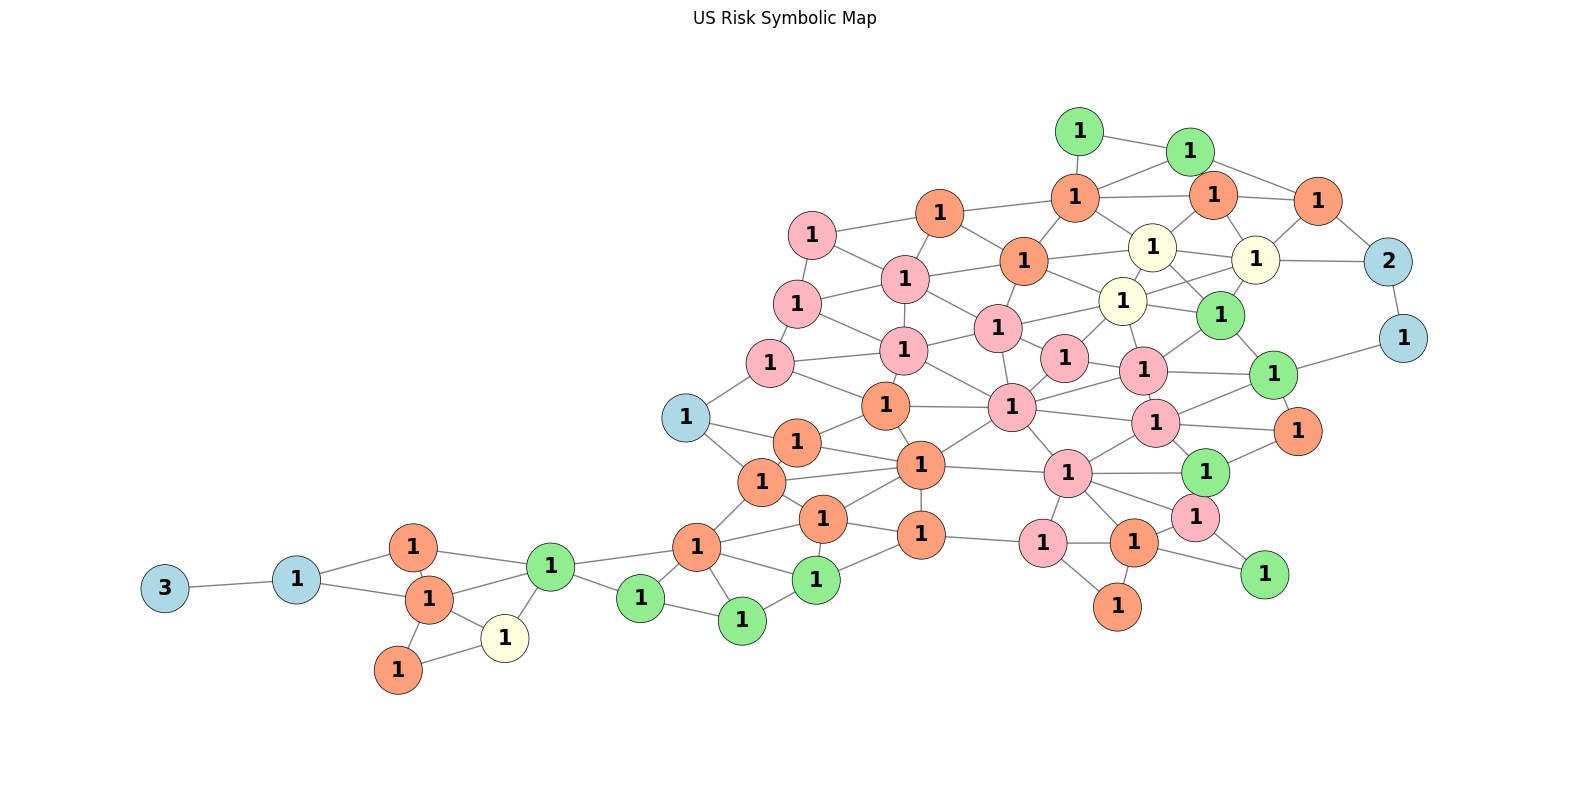

In [111]:
gamegraph, _, _ = risk_graph(prev_data[18]['game'], plot=True)

In [ ]:
sum_troops_edges_between_owners(gamegraph)

In [ ]:
gamegraph.nodes[0]

In [ ]:
prev_data

In [ ]:
np.mean([r for j in range(len(sim_results)) for r in sim_results[j] if r is not np.nan ])

In [ ]:
sim_results

In [ ]:
sim_results_2 = sim_results

In [ ]:
player_corr

In [ ]:
get_edges_df(PLAYER_COLORS[playing_player], shared_edges)

In [ ]:
player_corr[player_corr.index != PLAYER_COLORS[playing_player]]

In [ ]:
playing_player

In [ ]:
def step(game):
    current_player = game.player_turn
    game.players[current_player].get_minimax_move(game)

for _ in range(10):
    step(game=game)

In [ ]:
G, _, _ = risk_graph(game=game)

In [ ]:
node_owner = nx.get_node_attributes(G, 'owner')
node_owner
#list(G.nodes())

Explaining actions:

To explain the influence of an attack, we can compute P(attack|success)*utility_for_agents(attack|success) + P(attack|failute)*utility_for_agents(attack|failure)

In [ ]:
simulation_results

 {-1: 'lightgray',
  0: 'lightblue',
  1: 'lightpink',
  2: 'lightgreen',
  3: 'lightyellow',
  4: 'lightsalmon',
  5: 'lightcoral',
  6: 'lightcyan',
  7: 'mediumpurple'}

In [ ]:
import pandas as pd


pd.DataFrame(simulation_results).corr().iloc[current_player]

In [ ]:
current_player

In [ ]:
risk_graph(game)

In [ ]:
for i, terr in enumerate(game.json()['territories']):
    print(terr)
    player = terr['occupying_player']
    
    break

In [ ]:
all_states_risk = set([v for vals in game.json()['state'].values() for v in vals])

In [ ]:
all_states_risk

In [ ]:
territory_neighbors

In [ ]:
# https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

path = './us_map/tl_2020_us_state.shp'
df = gpd.read_file(path)
df = df.to_crs("EPSG:4326")

In [ ]:
len(df[df['NAME'].apply(lambda x: x in all_states_risk)])

In [ ]:
len(all_states_risk)

In [ ]:
from shapely.geometry import Point

non_continental = ['VI','MP','GU','PR']#'HI','AS''AK',
us49 = df.copy()
us49 = df[df['NAME'].apply(lambda x: x in all_states_risk)]
for n in non_continental:
    us49 = us49[us49.STUSPS != n]


us49.boundary.plot()
us49['centroid'] = us49.centroid


# New centroid coordinates for Hawaii
new_hawaii_centroid = Point(-130, 35)  # Replace with the desired new coordinates for Hawaii

# New centroid coordinates for Alaska
new_alaska_centroid = Point(-130, 50)  # Replace with the desired new coordinates for Alaska

# Update the geometry of Hawaii (assuming 'NAME' column contains state names)
us49.loc[us49['NAME'] == 'Hawaii', 'centroid'] = new_hawaii_centroid

# Update the geometry of Alaska
us49.loc[us49['NAME'] == 'Alaska', 'centroid'] = new_alaska_centroid


us49 = us49.reset_index()

plt.show()

In [ ]:
us49['centroid'].apply(lambda x: x.x).max()

In [ ]:
len(us49)

In [ ]:
len(us49['centroid'])

In [ ]:
for i in range(len(us49)):
    if i % 2 == 0:
        us49.at[i, 'owner'] = 0
    elif i % 3 == 0:
        us49.at[i, 'owner'] = 1
    elif i % 5 == 0:
        us49.at[i, 'owner'] = 3
    else:
        us49.at[i, 'owner'] = 4

In [ ]:
us49['owner'].unique()

In [ ]:
len(us49['centroid'])

In [ ]:
# Assuming you have a GeoDataFrame of US states called 'us49' with an 'owner' column containing values 1 to 7.

# Create a figure and axis
f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0, alpha=0.5)

# Replace 'owner' with the name of the column you want to use
plt.ylabel('Owner', fontsize=6)

# Define a list of 7 predefined colors
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink']
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightseagreen', 'lightpink', 'lightcyan', 'lavender']

#us49.plot(ax=ax, alpha=0.8, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1,label='Inline label')

# Iterate through colors and plot centroids with a different color if there are points
for i, color in enumerate(colors):
    subset = us49[us49['owner'] == i]  # Assuming owner values are 1 to 7
    if not subset.empty:
        subset['centroid'].plot(ax=ax, marker='o', color=color, markersize=40, label=f'Owner {i + 1}')

for i in range(len(us49['centroid'])):
    centroid = us49['centroid'].iloc[i]
    ax.annotate("1", xy=(centroid.x, centroid.y), fontsize=8, ha='center')
    ax.annotate(us49['NAME'].iloc[i], xy=(centroid.x, centroid.y), fontsize=2, ha='center')
ax.set_xlim(-150, -60)
# Add a legend
ax.legend(fontsize=6)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import cycle

# Assuming you have a GeoDataFrame of US states called 'us49' with an 'owner' column containing values 1 to 7.

# Create a figure and axis
f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0, alpha=0.5)

# Replace 'owner' with the name of the column you want to use
plt.ylabel('Owner', fontsize=6)

# Define a list of 7 predefined colors
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink']

# Create a cycle of the 7 colors
color_cycle = cycle(colors)

# Plot the centroids with colors based on the 'owner' column
for owner_value in range(1, 8):
    subset = us49[us49['owner'] == owner_value]
    color = next(color_cycle)  # Get the next color from the cycle
    subset['centroid'].plot(ax=ax, marker='o', color=color, markersize=100, label=f'Owner {owner_value}')

# Add a legend
ax.legend(fontsize=6)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming you have a GeoDataFrame of US states called 'us49' with an 'owner' column containing values 1 to 7 and possibly NaN.

# Define a list of 7 colors for the 7 possible values
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink']

# Create a figure and axis
f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0, alpha=0.5)

# Replace 'owner' with the name of the column you want to use
plt.ylabel('owner', fontsize=6)

# Fill NaN values in the 'owner' column with a default value, e.g., 0
us49['owner'].fillna(0, inplace=True)

# Plot the centroids with colors based on the 'owner' column values (1 to 7)
for i in range(1, 8):
    subset = us49[us49['owner'] == i]
    color = colors[i - 1]  # Assign a color from the list
    subset['centroid'].plot(ax=ax, marker='o', color=color, markersize=100, label=f'Owner {i}')

# Add a legend
ax.legend(fontsize=6)

plt.show()


In [ ]:

f,ax = plt.subplots(1,1, figsize=(8,8), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot(ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1,label='Inline label')
plt.ylabel('owner', fontsize=6)
us49['centroid'].plot(ax=ax, marker='o', color='green', markersize=100)

plt.show()

In [ ]:
us49.columns

In [ ]:
f,ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True, dpi=300)
plt.title('Simple Map of US States')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot(ax=ax, alpha=0.5, edgecolor='k', legend=True, cax=cax, linewidth=0.1)
plt.show()

In [ ]:
f,ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot('ALAND_miles', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1,label='Inline label')
plt.ylabel('Square miles', fontsize=6)
us49['centroid'].plot(ax=ax, marker='o', color='red', markersize=5)
plt.show()

In [ ]:
f,ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True, dpi=300)
plt.title('Simple Map of US States')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot('ALAND', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1)
plt.show()

In [ ]:
territory_neighbors

In [ ]:
territory_neighbors

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a graph
G = nx.Graph()

# Add edges based on your data
for node, edges in territory_neighbors.items():
    for edge in edges:
        G.add_edge(node, edge)

# Plot the graph
pos = nx.spring_layout(G, seed=42, k=0.5)  # Define the layout for better visualization
plt.figure(figsize=(12, 8))

nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')
plt.title("Your Graph")
plt.show()

In [ ]:
territory_neighbors

In [ ]:
game.json()['territories']